In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
from tabulate import tabulate

In [2]:
# Manual seeding for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# Use cuda if available else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Let's read user data file
user_data = pd.read_csv(
    "/home/dmitrii/vscode_projects/PMLDL/Assignment2/data/raw/ml-100k/u.data", 
    sep='\t',
    names=['user_id', 'movie_id', 'rating', 'timestamp']
)

In [5]:
genres = pd.read_csv('/home/dmitrii/vscode_projects/PMLDL/Assignment2/data/raw/ml-100k/u.genre',
                    names=["genre", "index"],
                    sep='|')
genres_list = genres.genre.to_list()

user_item_names = ['movie_id', 'movie_title', 'release_date', 'video_release_date,', 'imdb_url']
user_item_names.extend(genres_list)
user_item = pd.read_csv(
    "/home/dmitrii/vscode_projects/PMLDL/Assignment2/data/raw/ml-100k/u.item", 
    sep='|',
    encoding='latin-1',
    index_col=False,
    names=user_item_names
)

user_item.head()

,movie_id,movie_title,release_date,"video_release_date,",imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
class MovieDataset(Dataset):
    """
    Custom Movie Dataset. 
    """
    def __init__(self, user_ids, movie_ids, ratings):
        """
        Args:
            user_ids: ids of users
            movie_ids: ids of movies
            ratings: ratings of the corresponding movies
        """
        self.user_ids = user_ids
        self.movie_ids = movie_ids
        self.ratings = ratings

    def __len__(self):
        """
        Returns length of the dataset

        Returns:
            _type_: int
        """
        return len(self.user_ids)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): index of the required item

        Returns:
            _type_: dict
            user_ids: ids of the users
            movie_ids: ids of the movies
            ratings: ratings of the corresponding movies
        """
        sample = {
            "user_ids": torch.tensor(self.user_ids[idx], dtype=torch.long),
            "movie_ids": torch.tensor(self.movie_ids[idx], dtype=torch.long),
            "ratings": torch.tensor(self.ratings[idx], dtype=torch.float32)
        }
        return sample

In [7]:
class RecommendationModel(nn.Module):
    def __init__(self, n_users, n_movies):
        """
        Args:
            n_users (int): number of unique users
            n_movies (int): number of unique movies
        """
        super().__init__()

        self.user_embed = nn.Embedding(n_users, 96)
        self.movie_embed = nn.Embedding(n_movies, 64)

        self.fc1 = nn.Linear(160, 32)
        self.drop1 = nn.Dropout(p=0.5)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 32)
        self.drop2 = nn.Dropout(p=0.5)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)


    def forward(self, users, movies):
        """
        Forward function

        Args:
            users (torch.Tensor): ids of users
            movies (torch.Tensor): ids of movies

        Returns:
            float: rating of the input movie
        """

        # Embedding of user id
        user_id_embeds = self.user_embed(users)
        # Embedding of movie id
        movie_id_embeds = self.movie_embed(movies)

        x = torch.cat([user_id_embeds, movie_id_embeds], dim=1)

        x = self.fc1(x)
        x = self.drop1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return x

In [8]:
label_encoder_user = preprocessing.LabelEncoder()
label_encoder_movie = preprocessing.LabelEncoder()

user_data.user_id = label_encoder_user.fit_transform(user_data.user_id.values)
user_data.movie_id = label_encoder_movie.fit_transform(user_data.movie_id.values)

In [9]:
user_data.head()

,user_id,movie_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [10]:
# Let's split dataset into train and validation sets
train_split, val_split = train_test_split(
    user_data, test_size=0.4, random_state=seed, stratify=user_data.rating.values
)

val_split, test_split = train_test_split(
    val_split, test_size=0.5, random_state=seed, stratify=val_split.rating.values
)

In [11]:
test_split.to_csv('../benchmark/data/test_dataset.csv')

In [12]:
# Let's create train dataset
train_dataset = MovieDataset(
    user_ids=train_split.user_id.values,
    movie_ids=train_split.movie_id.values,
    ratings=train_split.rating.values,
)

# Creating valid dataset
valid_dataset = MovieDataset(
    user_ids=val_split.user_id.values,
    movie_ids=val_split.movie_id.values,
    ratings=val_split.rating.values,
)

# Creating test dataset
test_dataset = MovieDataset(
    user_ids=test_split.user_id.values,
    movie_ids=test_split.movie_id.values,
    ratings=test_split.rating.values,
)

In [13]:
train_batch_size = 16
test_batch_size = 16
epochs = 5

In [14]:
# Creating train dataloader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=2
)

# Creating valid dataloader
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=2,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=2,
    drop_last=True
)

In [15]:
# Neural network
model = RecommendationModel(
    n_users=len(label_encoder_user.classes_),
    n_movies=len(label_encoder_movie.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()


#### Run the training loop

In [16]:
from tqdm import tqdm

def train_model(model, train_loader, valid_loader, optimizer, loss_func):
    best_val_loss = 10000

    train_loss_list = []
    valid_loss_list = []

    model.train()
    for epoch in range(epochs):
        train_running_loss = 0
        for train_data in tqdm(train_loader):
            output = model(
                train_data["user_ids"].to(device),
                train_data["movie_ids"].to(device)
                        )

            rating = train_data["ratings"].view(train_batch_size, -1).to(torch.float32).to(device)

            loss = torch.sqrt(loss_func(output, rating))
            train_running_loss += loss.sum().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        valid_running_loss = 0
        with torch.no_grad():
            for valid_data in tqdm(valid_loader):
                output = model(
                    valid_data["user_ids"].to(device),
                    valid_data["movie_ids"].to(device)
                            )
                rating = valid_data["ratings"].view(test_batch_size, -1).to(torch.float32).to(device)
                loss = torch.sqrt(loss_func(output, rating))
                valid_running_loss += loss.sum().item()

        if valid_running_loss < best_val_loss:
                best_val_loss = valid_running_loss
                torch.save(model.state_dict(), '../models/best_model.pth')
        
        train_loss_list.append(train_running_loss/len(train_loader))
        valid_loss_list.append(valid_running_loss/len(valid_loader))

        print(f"Epoch {epoch+1} RMSE Train: {train_running_loss/len(train_loader)}")
        print(f"Epoch {epoch+1} RMSE Val: {valid_running_loss/len(valid_loader)}")
    return train_loss_list, valid_loss_list

In [17]:
train_loss_list, valid_loss_list = train_model(model, train_loader, valid_loader, optimizer, loss_func)

100%|██████████| 1250/1250 [00:02<00:00, 453.44it/s]


Epoch 1 RMSE Train: 1.3410077187856038
Epoch 1 RMSE Val: 1.035414297914505


100%|██████████| 1250/1250 [00:02<00:00, 540.41it/s]


Epoch 2 RMSE Train: 0.9861795550187429
Epoch 2 RMSE Val: 0.9683585852384567


100%|██████████| 1250/1250 [00:02<00:00, 467.85it/s]


Epoch 3 RMSE Train: 0.938709011220932
Epoch 3 RMSE Val: 0.9460544757843018


100%|██████████| 1250/1250 [00:01<00:00, 628.87it/s]


Epoch 4 RMSE Train: 0.9144578082720438
Epoch 4 RMSE Val: 0.9393261590480805


100%|██████████| 1250/1250 [00:03<00:00, 414.61it/s]

Epoch 5 RMSE Train: 0.8953319104830424
Epoch 5 RMSE Val: 0.9390732069969178


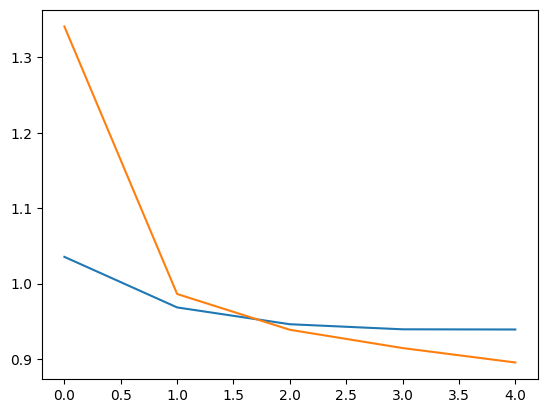

In [18]:
plt.figure()
plt.plot(valid_loss_list)
plt.plot(train_loss_list)
plt.show()

In [19]:
from collections import defaultdict

def get_rating_pairs(valid_loader, model):
    rating_pairs = defaultdict(list)

    with torch.no_grad():
        for data in valid_loader:
            user_ids = data['user_ids']
            movie_ids = data['movie_ids']
            ratings = data['ratings']

            output = model(
                user_ids.to(device), 
                movie_ids.to(device)
            )

            for i in range(len(user_ids)):
                user_id = user_ids[i].item()
                movie_id = user_ids[i].item()
                pred_rating = output[i][0].item()
                true_rating = ratings[i].item()

                rating_pair = {
                    'movie_id': movie_id,
                    "predicted_rating": pred_rating,
                    "true_rating": true_rating
                }
                rating_pairs[user_id].append(rating_pair)
    return rating_pairs

In [20]:
rating_pairs = get_rating_pairs(valid_loader, model)

In [21]:
def test_model(model, test_loader, loss_func):
    test_running_loss = 0
    with torch.no_grad():
        for test_data in tqdm(test_loader):
            output = model(
                test_data["user_ids"].to(device),
                test_data["movie_ids"].to(device)
                        )
            rating = test_data["ratings"].view(test_batch_size, -1).to(torch.float32).to(device)
            loss = torch.sqrt(loss_func(output, rating))
            test_running_loss += loss.sum().item()
    print(test_running_loss/len(test_loader))

In [22]:
test_model(model, test_loader, loss_func)

100%|██████████| 1250/1250 [00:02<00:00, 602.18it/s]

0.9468653615474701


In [23]:
def calculate_metrics(rating_pairs, k=10, threshold=3.5):
    precisions = {}
    recalls = {}
    for user_id, rating in rating_pairs.items():

        # Choosing the best movies based on predicted rating
        rating.sort(key=lambda x: x['predicted_rating'], reverse=True)

        # Let's calculate total number of relevant items
        
        total_relevant = sum(x['true_rating'] >= threshold for x in rating)

        # Number of top@k predicted relevant items
        n_rec_k = sum(x['predicted_rating'] >= threshold for x in rating[:k])

        # Number of recommended item @k that are relevant
        n_rel_and_rec_k = sum(
            ((x['true_rating'] >= threshold) and (x['predicted_rating'] >= threshold))
            for x in rating[:k]
        )

        precisions[user_id] = 0
        recalls[user_id] = 0
        if n_rec_k != 0:
            precisions[user_id] = n_rel_and_rec_k / n_rec_k

        if total_relevant != 0:
            recalls[user_id] = n_rel_and_rec_k / total_relevant
                
    print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")
    print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")
    return precisions, recalls

In [24]:
precisions, recalls = calculate_metrics(rating_pairs)

precision @ 10: 0.6856733802270458
recall @ 10 : 0.5177347709922385


In [25]:
class TestMovieDataset(Dataset):
    """
    Custom Movie Dataset. 
    """
    def __init__(self, user_ids, movie_ids):
        """
        Args:
            user_ids: ids of users
            movie_ids: ids of movies
        """
        self.user_ids = user_ids
        self.movie_ids = movie_ids

    def __len__(self):
        """
        Returns length of the dataset

        Returns:
            _type_: int
        """
        return len(self.user_ids)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): index of the required item

        Returns:
            _type_: dict
            user_ids: ids of the users
            movie_ids: ids of the movies
            ratings: ratings of the corresponding movies
        """
        sample = {
            "user_ids": torch.tensor(self.user_ids[idx], dtype=torch.long),
            "movie_ids": torch.tensor(self.movie_ids[idx], dtype=torch.long),
        }
        return sample

In [26]:
def recommend_movies(user_data, model, user_id=10, k=10):
    """This function recommends unwatched movies to a user

    Args:
        user_data (pandas Dataframe): Dataframe that contains data about movies, users and ratings
        model: neural nerwork used for prediction
        user_id (int): id of user. Defaults to 10.
        k (int): number of suggested movies. Defaults to 10.
    """
    # Let's find out which movies were watched
    watched_movies = user_data[user_data['user_id'] == user_id].movie_id
    unwatched_movie_ids = [x for x in user_data.movie_id.unique() if x not in watched_movies]
    user_ids = [user_id] * len(unwatched_movie_ids)

    # Let's find unwatched movies
    unwatched_movies_dataset = TestMovieDataset(user_ids, unwatched_movie_ids)
    unwatched_movies_dataloader = DataLoader(
        dataset=unwatched_movies_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2,
        drop_last=True
    )

    predicted_ratings = []

    # Let's predict ratings
    with torch.no_grad():
        for data in unwatched_movies_dataloader:
            user_ids = data['user_ids']
            movie_ids = data['movie_ids']

            output = model(
                user_ids.to(device), 
                movie_ids.to(device)
            ).reshape(-1)

            pair = zip(movie_ids.tolist(), output.tolist())
            predicted_ratings.extend(pair)
    # Let's sort ratings to find top-k movies
    predicted_ratings.sort(key=lambda x: x[1], reverse=True)
    df_ratings = [x[1] for x in predicted_ratings[:k]]

    df_columns = ["movie_id", "movie_title"]
    out_list = []

    for x in predicted_ratings[:k]:
        out_list.append(user_item[user_item["movie_id"]==x[0]][df_columns])
    df = pd.concat(out_list)
    df["rating"] = df_ratings
    print(f"User Id: {user_id}")
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))


In [27]:
recommend_movies(user_data, model, user_id=10, k=10)

User Id: 10
+------------+---------------------------------------------+----------+
|   movie_id | movie_title                                 |   rating |
|------------+---------------------------------------------+----------|
|        314 | 3 Ninjas: High Noon At Mega Mountain (1998) |  4.69503 |
|         11 | Seven (Se7en) (1995)                        |  4.49574 |
|        356 | Client, The (1994)                          |  4.4096  |
|        426 | Transformers: The Movie, The (1986)         |  4.40918 |
|        317 | In the Name of the Father (1993)            |  4.40259 |
|        133 | Gone with the Wind (1939)                   |  4.38433 |
|        173 | Princess Bride, The (1987)                  |  4.36835 |
|         63 | Santa Clause, The (1994)                    |  4.36796 |
|        168 | Monty Python and the Holy Grail (1974)      |  4.31899 |
|        407 | Spy Hard (1996)                             |  4.31507 |
+------------+--------------------------------------